## ReciSys: Rating & Text-Based Recipe Recommendation on Food.com

In this notebook I build and compare two main kinds of models on the Food.com dataset:

1. **Task 1 – Rating prediction with side features**  
   Predict a user's 1–5 star rating for a (user, recipe) pair using:
   - A custom neural model (SideFeatAttAE) that mixes user–item embeddings with recipe side features.
   - Classic baselines: global mean, user mean, item mean, and matrix factorization (SVD).

2. **Task 2 – Rating prediction from review text (NLP)**  
   Predict the rating directly from the *text* of a review using:
   - A fine-tuned DeBERTa regression model.
   - A TF-IDF + Ridge regression baseline.

I'll start with loading and exploring the data, then build the models, and finally compare them.


In [ ]:
# DATASET CITATION:

# Generating Personalized Recipes from Historical User Preferences
# Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
# EMNLP, 2019
# https://cseweb.ucsd.edu/~jmcauley/pdfs/emnlp19c.pdf
# Kaggle: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In [ ]:
!pip uninstall -y numpy scikit-surprise

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [2]:
!pip install 'numpy<2'
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2555849 sha256=c6a97d637a82f8fa697593b642e9d5c6306f6c284988294da0db95878f86d1e7
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [3]:
import kagglehub
import os
import ast
import itertools
import pandas as pd
import numpy as np
from collections import Counter
import scipy.sparse as sp

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV as GridSearch
from surprise import Dataset, Reader, SVD, SVDpp
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print(f"Using device: {DEVICE}")

Using device: cpu


In [5]:
path = kagglehub.dataset_download("shuyangli94/food-com-recipes-and-user-interactions")
print(path)
files = os.listdir(path)
print(files)

Using Colab cache for faster access to the 'food-com-recipes-and-user-interactions' dataset.
/kaggle/input/food-com-recipes-and-user-interactions
['RAW_interactions.csv', 'ingr_map.pkl', 'PP_recipes.csv', 'RAW_recipes.csv', 'interactions_train.csv', 'interactions_test.csv', 'PP_users.csv', 'interactions_validation.csv']


## Loading Food.com data

Here I load the Food.com Kaggle dataset using `kagglehub`, and separate it into:
- `RAW_recipes.csv`: one row per recipe (metadata, tags, nutrition).
- `RAW_interactions.csv`: one row per user–recipe interaction (rating, review text, date, etc.).

I also set a fixed random seed so that all splits and training runs are reproducible.


In [12]:
# Small helper to load all of the core Food.com tables from disk in one shot.

def load_raw_data(data_path):
    raw_recipes = pd.read_csv(os.path.join(data_path, "RAW_recipes.csv"))
    raw_interactions = pd.read_csv(os.path.join(data_path, "RAW_interactions.csv"))

    inter_train = pd.read_csv(os.path.join(data_path,"interactions_train.csv"))
    inter_val   = pd.read_csv(os.path.join(data_path,"interactions_validation.csv"))
    inter_test  = pd.read_csv(os.path.join(data_path,"interactions_test.csv"))

    pp_recipes = pd.read_csv(os.path.join(data_path,"PP_recipes.csv"))
    pp_users   = pd.read_csv(os.path.join(data_path,"PP_users.csv"))
    ingr_map   = pd.read_pickle(os.path.join(data_path,"ingr_map.pkl"))

    return {
        "raw_recipes": raw_recipes,
        "raw_interactions": raw_interactions,
        "inter_train": inter_train,
        "inter_val": inter_val,
        "inter_test": inter_test,
        "pp_recipes": pp_recipes,
        "pp_users": pp_users,
        "ingr_map": ingr_map,
    }

data = load_raw_data(path)

## Exploratory Data Analysis (EDA)

Here I sanity-check the dataset and get a feel for:

- How ratings are distributed (are users mostly positive?).
- How active users are (ratings per user).
- How popular recipes are (ratings per recipe).
- The long-tail structure and sparsity of the user–recipe matrix.

This helps justify later design choices for filtering, modeling, and evaluation.


In [ ]:
#######################################
### EDA - Exploratory Data Analysis ###
#######################################

In [13]:
# For convenience, keep references with shorter names for the rest of the notebook.

raw_recipes = data['raw_recipes']
raw_interactions = data['raw_interactions']
inter_train = data['inter_train']
inter_val = data['inter_val']
inter_test = data['inter_test']
pp_recipes = data['pp_recipes']
pp_users = data['pp_users']
ingr_map = data['ingr_map']

In [14]:
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid")

In [ ]:
# Quick sanity checks: look at shapes to make sure everything loaded correctly.

summary = []
for name, df in data.items():
    summary.append({
        "dataset": name,
        "n_rows": len(df),
        "n_cols": df.shape[1],
        "memory_mb": df.memory_usage(deep=True).sum() / (1024**2)
    })

summary_df = pd.DataFrame(summary).sort_values("n_rows", ascending=False)
summary_df

,dataset,n_rows,n_cols,memory_mb
1,raw_interactions,1132367,5,445.344283
2,inter_train,698901,6,65.985995
0,raw_recipes,231637,12,358.049544
5,pp_recipes,178265,8,235.866140
6,pp_users,25076,6,16.528898
4,inter_test,12455,6,1.176049
7,ingr_map,11659,7,2.549076
3,inter_val,7023,6,0.663194


In [ ]:
for name, df in data.items():
    print(f"\n=== {name} ===")
    null_counts = df.isna().sum()
    null_counts = null_counts[null_counts > 0]

    if len(null_counts) == 0:
        print("No null values.")
    else:
        print(null_counts)


=== raw_recipes ===
name              1
description    4979
dtype: int64

=== raw_interactions ===
review    169
dtype: int64

=== inter_train ===
No null values.

=== inter_val ===
No null values.

=== inter_test ===
No null values.

=== pp_recipes ===
No null values.

=== pp_users ===
No null values.

=== ingr_map ===
No null values.


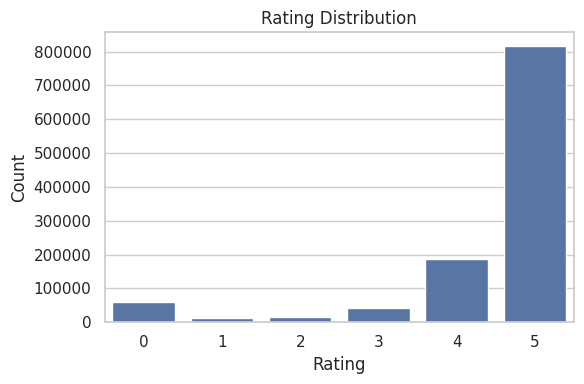

In [10]:
# Rating distribution

plt.figure(figsize=(6, 4))
sns.countplot(x="rating", data=raw_interactions)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

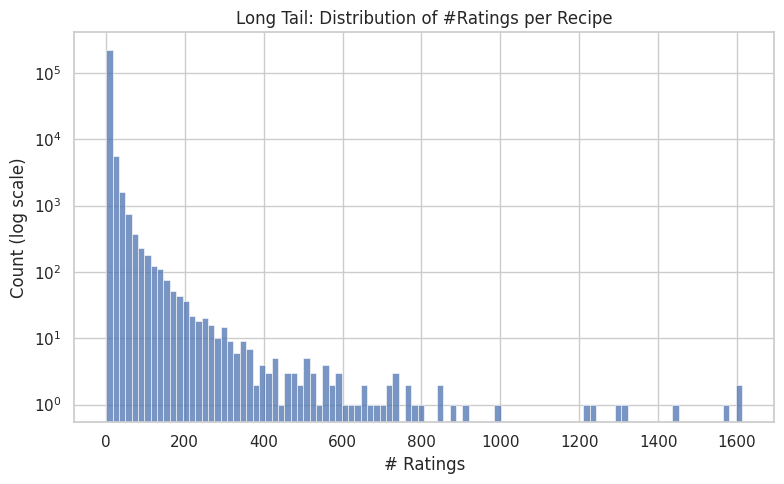

In [ ]:
# Count how many ratings each recipe gets to visualize the long-tail popularity pattern.

item_counts = raw_interactions["recipe_id"].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(item_counts, bins=100)
plt.yscale("log")
plt.title("Long Tail: Distribution of #Ratings per Recipe")
plt.xlabel("# Ratings")
plt.ylabel("Count (log scale)")
plt.tight_layout()
plt.show()

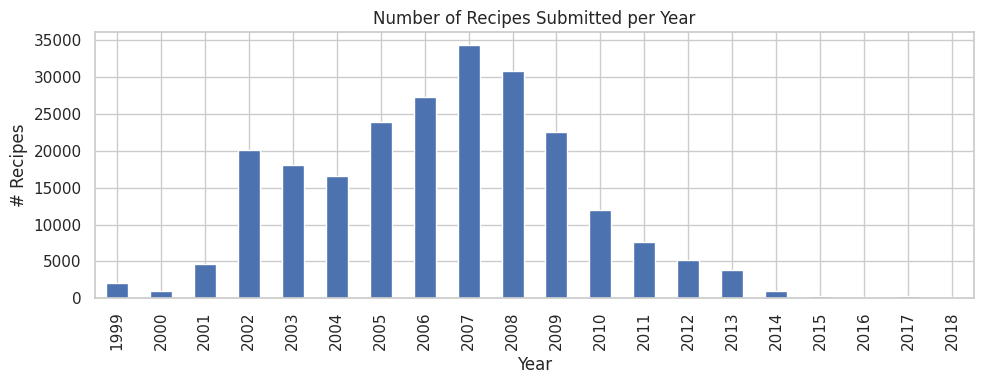

In [ ]:
# Plot how many recipes were submitted each year to see how the site evolved over time.

raw_recipes["submitted"] = pd.to_datetime(raw_recipes["submitted"])
recipes_per_year = raw_recipes.groupby(raw_recipes["submitted"].dt.year)["id"].count()

plt.figure(figsize=(10,4))
recipes_per_year.plot(kind="bar")
plt.title("Number of Recipes Submitted per Year")
plt.xlabel("Year")
plt.ylabel("# Recipes")
plt.tight_layout()
plt.show()


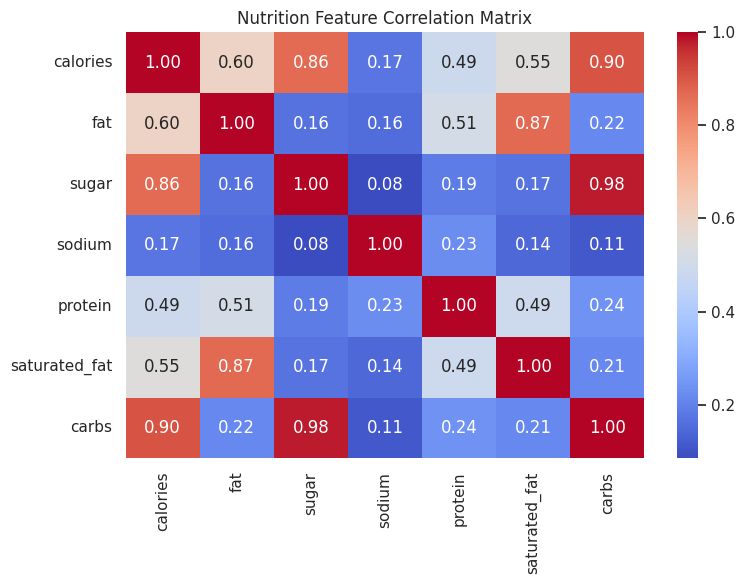

In [ ]:
nutr_cols = ["calories","fat","sugar","sodium","protein","saturated_fat","carbs"]
nutr_df = pd.DataFrame(raw_recipes["nutrition"].apply(eval).tolist(), columns=nutr_cols)

plt.figure(figsize=(8,6))
sns.heatmap(nutr_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Nutrition Feature Correlation Matrix")
plt.tight_layout()
plt.show()


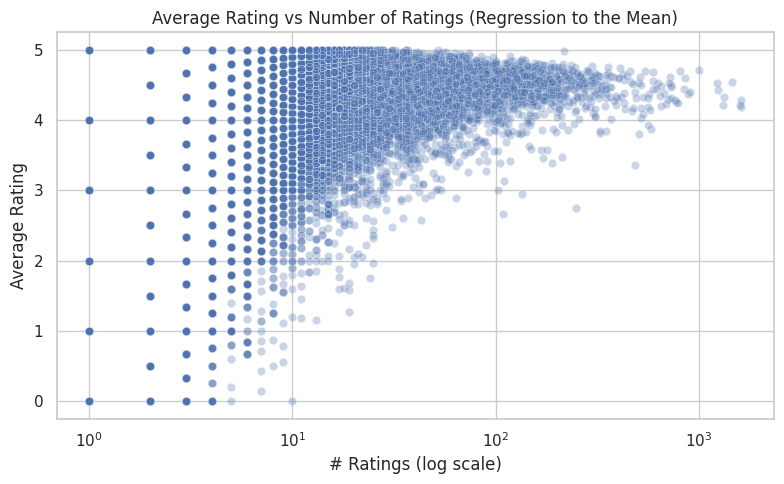

In [ ]:
recipe_stats = raw_interactions.groupby("recipe_id")["rating"].agg(["mean","count"])
recipe_stats.rename(columns={"mean":"avg_rating","count":"n_ratings"}, inplace=True)

plt.figure(figsize=(8,5))
sns.scatterplot(data=recipe_stats, x="n_ratings", y="avg_rating", alpha=0.3)
plt.xscale("log")
plt.title("Average Rating vs Number of Ratings (Regression to the Mean)")
plt.xlabel("# Ratings (log scale)")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.show()

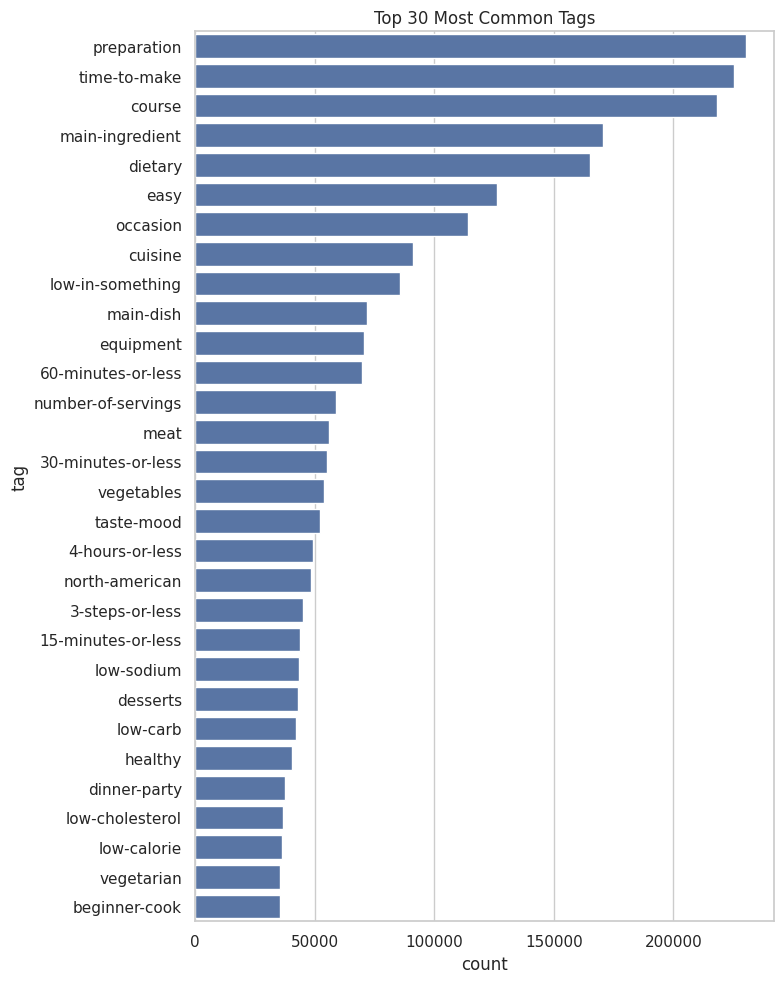

In [ ]:

tag_counter = Counter()

for t in raw_recipes["tags"].dropna():
    tag_counter.update(ast.literal_eval(t))

tags_df = pd.DataFrame(tag_counter.most_common(30), columns=["tag","count"])

plt.figure(figsize=(8,10))
sns.barplot(data=tags_df, x="count", y="tag")
plt.title("Top 30 Most Common Tags")
plt.tight_layout()
plt.show()

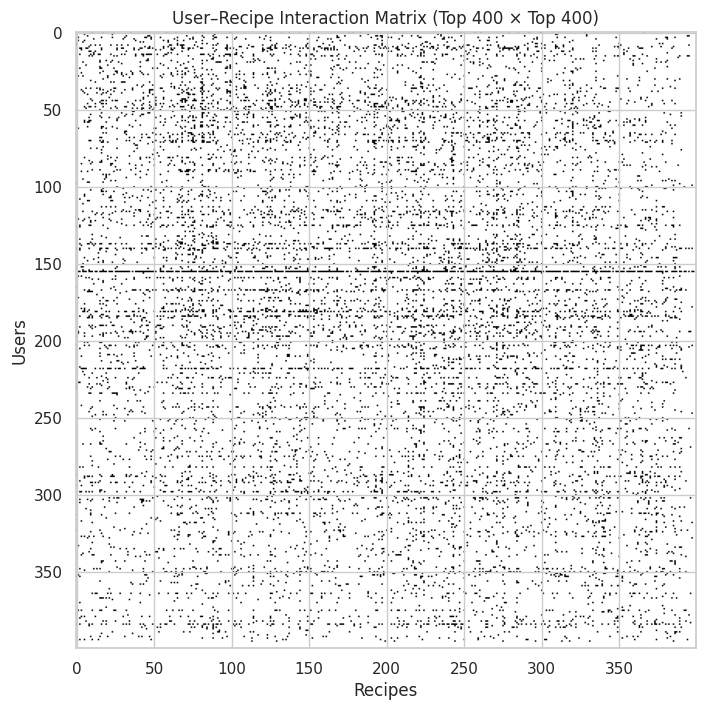

In [ ]:
# Visualize a small dense submatrix of (active users × popular recipes) to show sparsity structure.

# Build a 400x400 matrix
n = 400

user_counts = raw_interactions["user_id"].value_counts().head(n).index
item_counts = raw_interactions["recipe_id"].value_counts().head(n).index

subset = raw_interactions[
    raw_interactions["user_id"].isin(user_counts) &
    raw_interactions["recipe_id"].isin(item_counts)
].copy()

subset["u"] = subset["user_id"].astype("category").cat.codes
subset["i"] = subset["recipe_id"].astype("category").cat.codes

R = sp.coo_matrix(
    (np.ones(len(subset)), (subset["u"], subset["i"])),
    shape=(n, n)
).toarray()

plt.figure(figsize=(8, 8))
plt.imshow(R, aspect='auto', cmap="binary")
plt.title("User–Recipe Interaction Matrix (Top 400 × Top 400)")
plt.xlabel("Recipes")
plt.ylabel("Users")
plt.show()

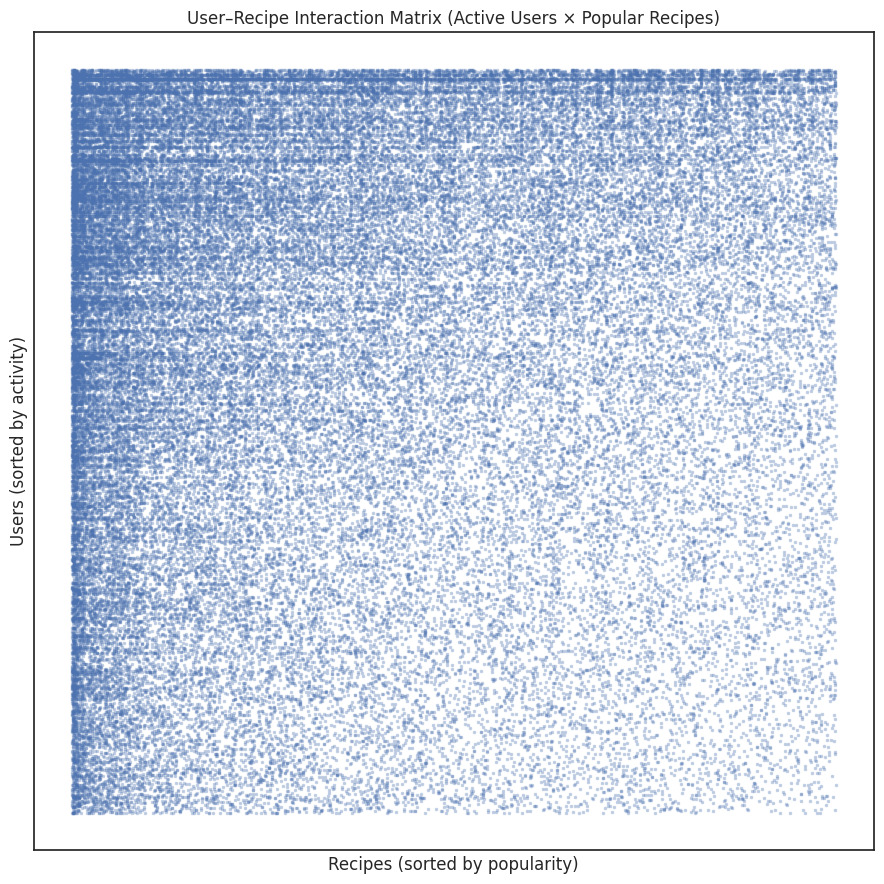

In [ ]:
sns.set(style="white")

# ===== CONFIG =====
MIN_USER_INTERACTIONS = 10    # keep users with >= this many ratings
MIN_ITEM_INTERACTIONS = 10    # keep recipes with >= this many ratings
TOP_USERS = 2000              # cap for performance / readability
TOP_ITEMS = 2000

# --- 1. Filter to active users & popular items ---
user_counts = raw_interactions["user_id"].value_counts()
item_counts = raw_interactions["recipe_id"].value_counts()

active_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
popular_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index

subset = raw_interactions[
    raw_interactions["user_id"].isin(active_users) &
    raw_interactions["recipe_id"].isin(popular_items)
].copy()

# --- 2. Sort users by activity and items by popularity ---
sorted_users = user_counts.loc[active_users].sort_values(ascending=False).head(TOP_USERS).index
sorted_items = item_counts.loc[popular_items].sort_values(ascending=False).head(TOP_ITEMS).index

subset = subset[
    subset["user_id"].isin(sorted_users) &
    subset["recipe_id"].isin(sorted_items)
].copy()

# Map to 0..N indices in sorted order
user_id_to_idx = {u: idx for idx, u in enumerate(sorted_users)}
item_id_to_idx = {i: idx for idx, i in enumerate(sorted_items)}

subset["u_idx"] = subset["user_id"].map(user_id_to_idx)
subset["i_idx"] = subset["recipe_id"].map(item_id_to_idx)

# Drop any rows that mapped to NaN (just in case)
subset = subset.dropna(subset=["u_idx", "i_idx"])

# --- 3. Plot cool sparse matrix (dot scatter) ---
plt.figure(figsize=(9, 9))
plt.scatter(
    subset["i_idx"],
    subset["u_idx"],
    s=2,            # dot size
    alpha=0.25,     # transparency
    marker="s"      # square pixels
)

plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("Recipes (sorted by popularity)")
plt.ylabel("Users (sorted by activity)")
plt.title("User–Recipe Interaction Matrix (Active Users × Popular Recipes)")

plt.tight_layout()

plt.show()

## Task 1: Rating Prediction with Side Features

Goal:  
Given a user and a recipe, predict the user's 1–5 star rating.

In this section I:

1. Build cleaned train/val/test splits with reasonable filters (active users, non-trivial recipes).
2. Engineer recipe side features (time, ingredients, nutrition, tags).
3. Build a PyTorch dataset and the SideFeatAttAE model (user+item embeddings + side features + attention).
4. Train with a small hyperparameter search and compare against simple baselines and matrix factorization.


In [ ]:
################################################################################
### RecSys Rating Prediction Task 1 - SideFeatRSAttAE & Matrix Factorization ###
################################################################################

In [ ]:
#### SideFeatRSAttAE ####

In [ ]:
# Load recipess and Interaction Data

recipes_df = raw_recipes.copy()
train_intxn = inter_train.copy()
val_intxn   = inter_val.copy()
test_intxn  = inter_test.copy()

In [ ]:
# -------------------------------------------------------------------
# Data Preprocessing:
# - keep recipes with 4–20 ingredients and >= 3 steps
# - keep interactions with rating > 0
# - keep users with >= 4 reviews (in TRAIN, after above filters)
# -------------------------------------------------------------------
# Build cleaned train/val/test splits for collaborative filtering.
# Filters out tiny recipes and keeps only reasonably active users/recipes.

def build_cf_splits(raw_recipes, inter_train, inter_val, inter_test,
                    min_steps=3, min_ingredients=4, max_ingredients=20, min_reviews=4):

    recipes_df = raw_recipes.copy()
    train = inter_train.copy()
    val   = inter_val.copy()
    test  = inter_test.copy()

    # 1) Recipe filtering
    # Keep only recipes with enough steps and a reasonable number of ingredients.
    recipes_df = recipes_df[
        (recipes_df["n_steps"] >= min_steps) &
        (recipes_df["n_ingredients"].between(min_ingredients, max_ingredients))
    ].copy()

    # Restrict future interactions to this cleaned set of recipe IDs.
    allowed_recipe_ids = set(recipes_df["id"])

    # 2) Interactions: rating>0 & allowed recipes
    # Drop non-positive ratings and interactions on recipes we just filtered out.
    train = train[(train["rating"] > 0.0) & (train["recipe_id"].isin(allowed_recipe_ids))].copy()
    val   = val[(val["rating"]   > 0.0) & (val["recipe_id"].isin(allowed_recipe_ids))].copy()
    test  = test[(test["rating"] > 0.0) & (test["recipe_id"].isin(allowed_recipe_ids))].copy()

    # 3) Active users (≥ min_reviews in TRAIN)
    # Compute how many ratings each user has in the training split.
    user_counts = train["user_id"].value_counts()
    active_users = user_counts[user_counts >= min_reviews].index

    # Keep only "active" users with at least `min_reviews` training ratings.
    train = train[train["user_id"].isin(active_users)].copy()
    val   = val[val["user_id"].isin(active_users)].copy()
    test  = test[test["user_id"].isin(active_users)].copy()

    return recipes_df, train, val, test

### 1.1 Building collaborative-filtering splits

Here I:

- Filter recipes by minimum steps and ingredient counts.
- Keep only interactions with positive ratings.
- Restrict to "active" users with at least 4 ratings in the training split.

This gives a denser, more stable subset to train recommender models on.


In [ ]:
recipes_df, train_intxn, val_intxn, test_intxn = build_cf_splits(
    raw_recipes, inter_train, inter_val, inter_test
)

### 1.2 Recipe feature engineering (tags + nutrition + basics)

I turn each recipe into a fixed-length feature vector by combining:

- Basic numeric info: minutes, number of steps, number of ingredients.
- Nutrition vector (7 fields from the dataset).
- Frequent tags (top T tags turned into a multi-hot encoding).

These features will be the side information fed into the SideFeatAttAE model.


In [ ]:
# Safely parse the 'tags' string into a cleaned list of lowercase tag names.

def parse_tags(x):
    try:
        tags = ast.literal_eval(x)
        if isinstance(tags, list):
            return [t.strip().lower() for t in tags]
        return []
    except Exception:
        return []

# Attach a parsed list of tags to each recipe.
recipes_df["tags_list"] = recipes_df["tags"].apply(parse_tags)

# keep rows with recipes that have been interacted with
# note: using test split only to collect recipe_id → i mappings (no test labels used).
# Only keep recipes that actually appear in at least one of the train/val/test splits.
item_ids_used = set(train_intxn["recipe_id"]) | set(val_intxn["recipe_id"]) | set(test_intxn["recipe_id"])
recipes_df = recipes_df[recipes_df["id"].isin(item_ids_used)].copy()

In [ ]:
# Item feature matrix
# Each recipe with fixed-dimensional feature vector: minutes, n_steps, n_ingredients, nutrition, tags


# note: test split used only to include item IDs in the feature matrix; no test interactions used.
# Map original recipe_id values to a compact 0..(n_items-1) index space for PyTorch.

id_to_i = (
    pd.concat([train_intxn, val_intxn, test_intxn])
      .drop_duplicates("recipe_id")
      .set_index("recipe_id")["i"]
      .to_dict()
)

# Compute the total number of users and items after remapping.
n_users = (pd.concat([train_intxn, val_intxn, test_intxn])["u"].max() + 1)
n_items = max(id_to_i.values()) + 1
print("Number of items:", n_items, "Number of users:", n_users)

# Nutrition is a 7-length list in string form: "[51.5, 0.0, ...]"
# Parse the nutrition field (stored as a stringified 7-length list) into a numeric list.
# If anything goes wrong, fall back to a zero-vector.
def parse_nutrition(x):
    try:
        vals = ast.literal_eval(x)
        return vals if isinstance(vals, list) else [0.0]*7
    except Exception:
        return [0.0]*7

# Apply the nutrition parser so each recipe has a 7-dim nutrition vector.
recipes_df["nutrition_list"] = recipes_df["nutrition"].apply(parse_nutrition)

# nutrition as features
nutrition_features = np.array(recipes_df["nutrition_list"].tolist())

Number of items: 178265 Number of users: 25056


In [ ]:
# Build MultiLabelBinarizer for tags (limit vocab size to top T tags)

# Count tag frequencies and keep only the top T tags so the tag space doesn't blow up.
T = 200  # top 200 tags
all_tags = [tag for tags in recipes_df["tags_list"] for tag in tags]
tag_counts = pd.Series(all_tags).value_counts()
top_tags = set(tag_counts.head(T).index)
print(f"Top 10 tags: {list(tag_counts.head(10).index)}")

# For each recipe, keep only tags that are in the top-T frequent tags.
recipes_df["tags_top"] = recipes_df["tags_list"].apply(
    lambda tags: [t for t in tags if t in top_tags]
)

# Turn the list of tags per recipe into a multi-hot binary matrix.
mlb = MultiLabelBinarizer()
tag_features = mlb.fit_transform(recipes_df["tags_top"])

Top 10 tags: ['preparation', 'time-to-make', 'course', 'main-ingredient', 'dietary', 'easy', 'occasion', 'cuisine', 'low-in-something', 'equipment']


In [ ]:
# Numeric features

# Basic numeric recipe features: time, number of steps, and number of ingredients.
numeric_features = np.vstack([
    recipes_df["minutes"].values,
    recipes_df["n_steps"].values,
    recipes_df["n_ingredients"].values
]).T

num_feat = np.hstack([numeric_features, nutrition_features])

# Standardize numeric features so they're on a similar scale before concatenation.
scaler = StandardScaler()
num_feat_scaled = scaler.fit_transform(num_feat)

In [ ]:
# Final raw item feature matrix: [scaled numeric | nutrition | binary tag indicators].
item_features_raw = np.hstack([num_feat_scaled, tag_features])

feat_dim = item_features_raw.shape[1]
print("Item feature dimensions:", feat_dim) # 200 tags, 7 nutritional markers, mins, steps, n_ing = 210

# dense matrix of shape (n_items, feat_dim)
item_feature_matrix = np.zeros((n_items, feat_dim), dtype=np.float32)

for pos, rid in enumerate(recipes_df["id"].values):
    if rid in id_to_i:
        internal_i = id_to_i[rid]
        item_feature_matrix[internal_i] = item_features_raw[pos]

# Convert the numpy item feature matrix into a Torch tensor so it can go on the device.
item_feature_tensor = torch.tensor(item_feature_matrix)

Item feature dimensions: 210


### 1.3 PyTorch dataset and DataLoaders

I now:

- Map (user_id, recipe_id) to contiguous integer indices.
- Build a `RatingsDataset` that returns `(user_index, item_index, item_features, rating)` for each row.
- Wrap everything in DataLoaders for mini-batch training.


In [ ]:
# n_users, n_items, item_feature_tensor (n_items, feat_dim)
# create pytorch dataset where every row represents user-item-rating triple
# want to fetch minibatches

# Custom PyTorch Dataset for (user, item, item_features, rating) tuples.
class RatingsDataset(Dataset):
  def __init__(self, df, item_feat_tensor):
    # Store user indices, item indices, and ratings as tensors for easy batching.
    self.u = torch.tensor(df["u"].values, dtype=torch.long)
    self.i = torch.tensor(df["i"].values, dtype=torch.long)
    self.r = torch.tensor(df["rating"].values, dtype=torch.float32)
    self.item_feat_tensor = item_feat_tensor

  def __len__(self):
    return len(self.u)

  def __getitem__(self, idx):
    # Look up the feature vector for this recipe index.
    u = self.u[idx]
    i = self.i[idx]
    r = self.r[idx]
    # lookup features for the recipe
    x_item = self.item_feat_tensor[i]
    return u, i, x_item, r

# Wrap each split into a RatingsDataset so we can feed it to DataLoaders.
batch_size = 1024
train_dataset = RatingsDataset(train_intxn, item_feature_tensor)
val_dataset = RatingsDataset(val_intxn, item_feature_tensor)
test_dataset = RatingsDataset(test_intxn, item_feature_tensor)

# Standard DataLoader setup: shuffle train, keep val/test deterministic.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1.4 SideFeatAttAE model and training loop

SideFeatAttAE architecture:

- User and item embeddings (like matrix factorization).
- A small MLP to project recipe side features into the same embedding space.
- Multi-head attention over `[user_emb, item_emb, side_feat_emb]` to let the model decide how much to rely on each part.
- A small MLP head + user/item/global biases to output the rating.

Below I define the model, a generic `run_epoch` helper, and a training function that supports a small hyperparameter search.


In [ ]:
# SideFeat-AttAE
# Learn user and recipe embeddings
# project item features into some latent space
# stack [user_emb, item_emb, side_emb] as 3 "tokens"
# run multi-headed attention layer over , letting these three "tokens" interact
# pool and feed into MLP -> predict rating

# SideFeatAttAE: combines user/item embeddings with recipe side features using attention.
class SideFeatAttAE(nn.Module):
  def __init__(self, n_users, n_items, feat_dim, emb_dim=64, attn_heads=2, hidden_dim=64):
    super().__init__()
    # standard MF-style (K = emb_dim)
    self.user_emb = nn.Embedding(n_users, emb_dim)
    self.item_emb = nn.Embedding(n_items, emb_dim)

    # Project high-dimensional side features down into the same embedding space
    # (dim reduction with nonlin tranformation)
    self.side_mlp = nn.Sequential(
      nn.Linear(feat_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, emb_dim)
    )

    # Multi-head attention over [user_emb, item_emb, side_feat_emb] to let the model re-weight them.
    self.attn = nn.MultiheadAttention(embed_dim=emb_dim, num_heads=attn_heads, batch_first=True)

    # Small MLP to turn the attended embedding into a single rating prediction.
    self.out_mlp = nn.Sequential(
      nn.Linear(emb_dim, emb_dim),
      nn.ReLU(),
      nn.Linear(emb_dim, 1)
    )

    # User, item, and global bias terms (as in standard MF) to capture easy offsets.
    self.user_bias = nn.Embedding(n_users, 1)
    self.item_bias = nn.Embedding(n_items, 1)
    self.global_bias = nn.Parameter(torch.zeros(1))

    self._init_weights()

  def _init_weights(self):
    # Initialize embeddings with small random values for stable training.
    nn.init.normal_(self.user_emb.weight, std=0.01)
    nn.init.normal_(self.item_emb.weight, std=0.01)
    nn.init.normal_(self.item_bias.weight, std=0.01)
    nn.init.normal_(self.user_bias.weight, std=0.01)


  def forward(self, u, i, x_item):
    # Look up user/item embeddings and project side features.
    # B = batch size, D = emb_dim (K)
    # u, i: (B,)
    # x_item: (B, feat_dim)

    # (B, D)
    u_emb = self.user_emb(u)
    i_emb = self.item_emb(i)
    s_emb = self.side_mlp(x_item)

    # concat embeddings (stack as 3 tokens) (B, 3, D) for the attention layer.
    # 3 tokens per example: user emb, item emb, side-feat emb
    tokens = torch.stack([u_emb, i_emb, s_emb], dim=1)

    # Run multi-head attention over the sequence; use the output as a combined representation.
    attn_out, _ = self.attn(tokens, tokens, tokens) # (B, 3, D)

    pooled = attn_out.mean(dim=1) # (B, D)
    base = self.out_mlp(pooled).squeeze(-1) # (B,)

    # Add user/item/global biases and squeeze to get a scalar rating prediction.
    ub = self.user_bias(u).squeeze(-1)
    ib = self.item_bias(i).squeeze(-1)

    return self.global_bias + ub + ib + base


In [ ]:

# Small factory to build a SideFeatAttAE model with a given hyperparameter config.
def build_model(hparams, n_users, n_items, feat_dim):
    model = SideFeatAttAE(
        n_users=n_users,
        n_items=n_items,
        feat_dim=feat_dim,
        emb_dim=hparams["emb_dim"],
        attn_heads=hparams["attn_heads"],
        hidden_dim=hparams["hidden_dim"],
    ).to(DEVICE)
    return model

# Run a single pass over a DataLoader.
# If an optimizer is provided, this does training; otherwise it just evaluates.
def run_epoch(model, loader, optimizer=None, criterion=None):
    train = optimizer is not None
    if train:
        model.train()
    else:
        model.eval()

    total_loss, total_n = 0.0, 0

    # Loop over mini-batches of (user, item, features, rating).
    for u, i, x_item, r in loader:
        u = u.to(DEVICE)
        i = i.to(DEVICE)
        x_item = x_item.to(DEVICE)
        r = r.to(DEVICE)

        # Only track gradients when we're in training mode.
        with torch.set_grad_enabled(train):
            preds = model(u, i, x_item)
            loss = criterion(preds, r) if criterion is not None else 0.0

            # Standard training step: backprop and update parameters.
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if criterion is not None:
            total_loss += loss.item() * len(r)
        total_n += len(r)

    if criterion is None or total_n == 0:
        return None

    # Average MSE over all examples in this epoch.
    mse = total_loss / total_n
    return mse


def train_and_eval(hparams, train_loader, val_loader, n_users, n_items, feat_dim, max_epochs=10, patience=3):
    model = build_model(hparams, n_users, n_items, feat_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=hparams["lr"],
        weight_decay=hparams["weight_decay"],
    )

    best_val_mse = float("inf")
    best_state = None
    patience_left = patience

    # Track best validation performance and stop when it stops improving.
    for epoch in range(1, max_epochs + 1):
        train_mse = run_epoch(model, train_loader, optimizer, criterion)
        val_mse = run_epoch(model, val_loader, optimizer=None, criterion=criterion)

        print(
            f"[{hparams}] Epoch {epoch:02d} | "
            f"train MSE={train_mse:.4f} | val MSE={val_mse:.4f}"
        )

        if val_mse < best_val_mse - 1e-4:
            best_val_mse = val_mse
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left == 0:
                break

    # restore best state
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val_mse


In [ ]:
# Grid Search trained evaluated on MSE

feat_dim = item_feature_tensor.shape[1]

param_grid = {
    "emb_dim":      [32, 64],
    "hidden_dim":   [64, 128],
    "attn_heads":   [2, 4],
    "lr":           [1e-3, 5e-4],
    "weight_decay": [1e-5, 1e-4],
}

# Simple helper to iterate over all combinations in a hyperparameter grid.
def dict_product(d):
    keys = d.keys()
    for values in itertools.product(*d.values()):
        yield dict(zip(keys, values))

best_overall_mse = float("inf")
best_overall_config = None
best_overall_model = None

for hparams in dict_product(param_grid):
    print("\n=== Testing config:", hparams, "===\n")
    model, val_mse = train_and_eval(
        hparams,
        train_loader,
        val_loader,
        n_users,
        n_items,
        feat_dim,
        max_epochs=15,
        patience=3,
    )
    if val_mse < best_overall_mse:
        best_overall_mse = val_mse
        best_overall_config = hparams
        best_overall_model = model

print("\nBest config:", best_overall_config)
print("Best val MSE:", best_overall_mse)



=== Testing config: {'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05} ===

[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 01 | train MSE=1.3376 | val MSE=0.7136
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 02 | train MSE=0.3156 | val MSE=0.7037
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 03 | train MSE=0.2954 | val MSE=0.6943
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 04 | train MSE=0.2860 | val MSE=0.6893
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 05 | train MSE=0.2788 | val MSE=0.7029
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e-05}] Epoch 06 | train MSE=0.2727 | val MSE=0.6937
[{'emb_dim': 32, 'hidden_dim': 64, 'attn_heads': 2, 'lr': 0.001, 'weight_decay': 1e

In [ ]:
# Train model

model_history = {
    "epoch": [],
    "train_mse": [],
    "val_mse": [],
}

model = SideFeatAttAE(
    n_users=n_users,
    n_items=n_items,
    feat_dim=item_feature_tensor.shape[1],
    emb_dim=64,
    attn_heads=4,
    hidden_dim=128,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-05)
criterion = nn.MSELoss()

n_epochs = 9
for epoch in range(n_epochs):
    train_mse = run_epoch(model, train_loader, optimizer, criterion)
    val_mse   = run_epoch(model, val_loader, None,       criterion)
    print(f"Epoch {epoch:02d} | train MSE={train_mse:.4f} | val MSE={val_mse:.4f}")

    model_history["epoch"].append(epoch)
    model_history["train_mse"].append(train_mse)
    model_history["val_mse"].append(val_mse)

test_mse = run_epoch(model, test_loader, None, criterion)
print("Final test MSE:", test_mse)

Epoch 00 | train MSE=1.0655 | val MSE=0.7268
Epoch 01 | train MSE=0.3217 | val MSE=0.7056
Epoch 02 | train MSE=0.3036 | val MSE=0.6940
Epoch 03 | train MSE=0.2933 | val MSE=0.6886
Epoch 04 | train MSE=0.2862 | val MSE=0.6846
Epoch 05 | train MSE=0.2793 | val MSE=0.6835
Epoch 06 | train MSE=0.2719 | val MSE=0.6994
Epoch 07 | train MSE=0.2649 | val MSE=0.6926
Epoch 08 | train MSE=0.2593 | val MSE=0.6858
Final test MSE: 0.7120573004122267


### 1.5 Baselines and comparison

To put SideFeatAttAE in context, I compare against:

- Global mean predictor.
- User mean and item mean models.
- Matrix factorization (SVD) with grid search over a few hyperparameters.

All models are evaluated using MSE on the held-out test set.


In [ ]:
#### Matrix Factorization ####

In [ ]:
# For MF, merge train and val so SVD can train on more data; we still evaluate on the held-out test set.
trainval = pd.concat([train_intxn, val_intxn], ignore_index=True)

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(trainval[['user_id', 'recipe_id', 'rating']], reader)

# Small hyperparameter grid over number of factors, epochs, learning rate, and regularization.
param_grid = {
    "n_factors": [20, 70],
    "n_epochs":  [20, 50],
    "lr_all":    [0.002, 0.005],
    "reg_all":   [0.05, 0.1],
}

# Use Surprise's GridSearchCV to pick the best SVD configuration by validation RMSE.
gs = GridSearchCV(
    algo_class=SVD,
    param_grid=param_grid,
    measures=["mse"],
    cv=3,
    n_jobs=-1
)

gs.fit(data)

print("Best CV MSE:", gs.best_score["mse"])
print("Best params:", gs.best_params["mse"])

Best CV MSE: 0.3487057566508966
Best params: {'n_factors': 20, 'n_epochs': 50, 'lr_all': 0.002, 'reg_all': 0.1}


In [ ]:
# Refit the best SVD model on the full train+val data before evaluating on test.

reader = Reader(rating_scale=(1, 5))
trainset = Dataset.load_from_df(train_intxn[['u', 'i', 'rating']], reader).build_full_trainset()
model = SVD(n_factors=20, n_epochs= 50, lr_all= 0.002, reg_all= 0.1)
model.fit(trainset)

# Compute test predictions from the MF model and measure MSE.

mf_val_mse = mean_squared_error(val_intxn.rating, [model.predict(row.u, row.i).est for row in val_intxn.itertuples(index=False)])
print(f"Validation Mean Squared Error: {mf_val_mse}")

mf_test_mse = mean_squared_error(test_intxn.rating, [model.predict(row.u, row.i).est for row in test_intxn.itertuples(index=False)])
print(f"Test Mean Squared Error: {mf_test_mse}")

Validation Mean Squared Error: 0.7200684872292181
Test Mean Squared Error: 0.7533728322155789


In [ ]:
# Baseline 1: always predict the global mean rating from the training set.

global_mean = train_intxn["rating"].mean()

global_mean_val_mse = mean_squared_error(val_intxn.rating, [global_mean] * len(val_intxn))
global_mean_test_mse = mean_squared_error(test_intxn.rating, [global_mean] * len(test_intxn))

print(f"Validation Mean Squared Error, Global Mean Baseline: {global_mean_val_mse}")
print(f"Test Mean Squared Error, Global Mean Baseline: {global_mean_test_mse}")

Validation Mean Squared Error, Global Mean Baseline: 0.8193260223597847
Test Mean Squared Error, Global Mean Baseline: 0.8450298208442432


In [ ]:
# Baseline 2: predict each recipe's average training rating (fallback to global mean).

item_mean = train_intxn.groupby("i")["rating"].mean().to_dict()

preds = [item_mean.get(row.i, global_mean) for row in val_intxn.itertuples(index=False)]
test_preds = [item_mean.get(row.i, global_mean) for row in test_intxn.itertuples(index=False)]

item_mean_val_mse = mean_squared_error(val_intxn.rating, preds)
item_mean_test_mse = mean_squared_error(test_intxn.rating, test_preds)

print(f"Validation Mean Squared Error, Item Mean Baseline: {item_mean_val_mse}")
print(f"Test Mean Squared Error, Item Mean Baseline: {item_mean_test_mse}")

Validation Mean Squared Error, Item Mean Baseline: 0.8193260223597847
Test Mean Squared Error, Item Mean Baseline: 0.8450298208442432


In [ ]:
# Baseline 3: for each test point, predict that user's average training rating (fallback to global mean).

user_mean = train_intxn.groupby("u")["rating"].mean().to_dict()

preds = [user_mean.get(row.u, global_mean) for row in val_intxn.itertuples(index=False)]
test_preds = [user_mean.get(row.u, global_mean) for row in test_intxn.itertuples(index=False)]

user_mean_val_mse = mean_squared_error(val_intxn.rating, preds)
user_mean_test_mse = mean_squared_error(test_intxn.rating, test_preds)

print(f"Validation Mean Squared Error, User Mean Baseline: {user_mean_val_mse}")
print(f"Test Mean Squared Error, User Mean Baseline: {user_mean_test_mse}")

Validation Mean Squared Error, User Mean Baseline: 0.7166930338388942
Test Mean Squared Error, User Mean Baseline: 0.7535349801556871


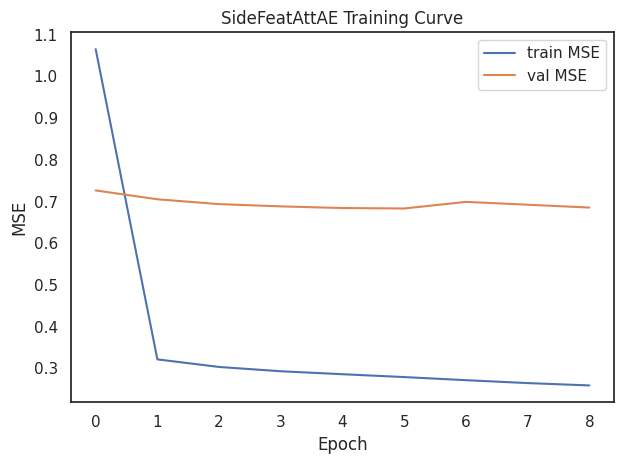

In [ ]:
plt.figure()
plt.plot(model_history["epoch"], model_history["train_mse"], label="train MSE")
plt.plot(model_history["epoch"], model_history["val_mse"], label="val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("SideFeatAttAE Training Curve")
plt.legend()
plt.tight_layout()
plt.show()

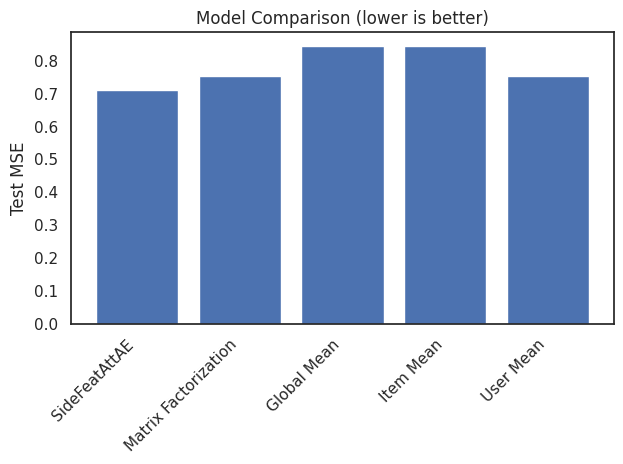

In [ ]:
results_df = {
    "SideFeatAttAE": test_mse,
    "Matrix Factorization": mf_test_mse,
    "Global Mean": global_mean_test_mse,
    "Item Mean": item_mean_test_mse,
    "User Mean": user_mean_test_mse
}
plt.figure()
bars = plt.bar(results_df.keys(), results_df.values())
plt.ylabel("Test MSE")
plt.title("Model Comparison (lower is better)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [8]:
print("Test MSE", "\nSideFeatAttAE: 0.712", "\nMatrix Fact: 0.75337", "\nGlobal Mean: 0.845", "\nItem Mean: 0.845", "\nUser Mean: 0.75353")

Test MSE 
SideFeatAttAE: 0.712 
Matrix Fact: 0.75337 
Global Mean: 0.845 
Item Mean: 0.845 
User Mean: 0.75353


## Task 2: Rating Prediction from Review Text (NLP)

New goal:  
Given the text of a review, predict the rating (1–5 stars) the user gave.

This is a slightly different task than Task 1: instead of using user–item IDs and side features, we only use natural language text.


In [ ]:
#####################################################################################
### NLP Rating Prediction Task 2 - Fine-Tuned DaBERTa & TF-IDF + Ridge regression ###
#####################################################################################

In [ ]:
#### Fine-Tuned DaBERTa Transformer ####

### 2.1 Joining review text with rating splits

Here I attach the raw review strings to the same interaction splits used above:

- Keep only rows with positive ratings.
- Drop any interactions that don't have review text.

This gives train/val/test datasets of `(review_text, rating)` pairs.


In [15]:
# load splits to join with RAW interaction data
# Join a (user_id, recipe_id, date, rating) split with the raw review text.
def attach_reviews(split_df, raw_df):
    merged = split_df.merge(
        raw_df[["user_id", "recipe_id", "date", "review"]],
        on=["user_id", "recipe_id", "date"],
        how="left",
    )
    # Keep only interactions with strictly positive ratings.
    merged = merged[merged["rating"] > 0]
    # Drop rows that don't actually have any review text.
    merged = merged.dropna(subset=["review"])
    return merged

# Build train/val/test splits that include both rating and review text.
train_nlp = attach_reviews(inter_train, raw_interactions)
val_nlp   = attach_reviews(inter_val,   raw_interactions)
test_nlp  = attach_reviews(inter_test,  raw_interactions)

### 2.2 Fine-tuning DeBERTa for rating regression

Model setup:

- Base model: `microsoft/deberta-v3-small`.
- Add a regression head on top to predict a single rating value.
- Fine-tune on the training reviews and evaluate via MSE on val and test.

I use HuggingFace's `Trainer` API to handle the training loop.


In [12]:
model_name = "microsoft/deberta-v3-small" # microsoft/deberta-v3-base
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [13]:
# Simple Dataset wrapper for (review_text, rating) pairs for the transformer model.
class ReviewDataset(Dataset):
  def __init__(self, df, tokenizer, max_length=128):
    self.texts = df["review"].astype(str).tolist()
    self.ratings = df["rating"].astype(float).tolist()
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    # Tokenize the raw review text into input IDs and attention masks.
    text = self.texts[idx]
    rating = self.ratings[idx]

    enc = self.tokenizer(
      text,
      padding="max_length",
      truncation=True,
      max_length=self.max_length,
      return_tensors="pt",
    ) # (1, max_length) - trim to max_length tokens as part of tokenization

    item = {k: v.squeeze(0) for k, v in enc.items()} #(max_length,)
    item["labels"] = torch.tensor(rating, dtype=torch.float) #HuggingFace Trainer expects target under "labels"
    return item

train_ds = ReviewDataset(train_nlp, tokenizer)
val_ds   = ReviewDataset(val_nlp, tokenizer)
test_ds  = ReviewDataset(test_nlp, tokenizer)

In [14]:
def compute_metrics(eval_pred):
  # Compute MSE (and optionally other metrics) from model predictions and true labels.
  preds, labels = eval_pred
  preds = preds.reshape(-1)
  labels = labels.reshape(-1)
  mse = mean_squared_error(labels, preds)
  return {"mse": mse}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
  model_name,
  num_labels=1,
  problem_type="regression",
)

# HuggingFace Trainer config: batch sizes, learning rate, number of epochs, etc.
training_args = TrainingArguments(
  output_dir="./deberta-rating",
  eval_strategy="epoch", #evaluate val every epoch
  save_strategy="epoch", #checkpoint every epoch
  learning_rate=2e-5,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=32,
  num_train_epochs=1,
  weight_decay=0.01,
  load_best_model_at_end=True, # after training, load checkpoint with lowest val MSE
  metric_for_best_model="mse",
  greater_is_better=False,
  logging_steps=200,
  bf16=True # if on GPU
)

# Tie together model, data, tokenizer, and metrics into a Trainer for fine-tuning.
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_ds,
  eval_dataset=val_ds,
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
)

# Fine-tune DeBERTa on the review text to predict ratings.
trainer.train()

# Evaluate the fine-tuned model on the held-out test split.
test_metrics = trainer.evaluate(test_ds)
print("Transformer MSE (test):", test_metrics["eval_mse"])

In [17]:
# Trained on A100 GPU, Ran out of compute units for second run, "You currently have 0 compute units". Here was original output:

print("""
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-64210721.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
 [42622/42622 40:00, Epoch 1/1]
Epoch\tTraining Loss\tValidation Loss\tMse
1\t0.142100\t0.278826\t0.278826
 [368/368 00:13]
Transformer MSE (test): 0.2860561013221741
""")



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-64210721.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
 [42622/42622 40:00, Epoch 1/1]
Epoch	Training Loss	Validation Loss	Mse
1	0.142100	0.278826	0.278826
 [368/368 00:13]
Transformer MSE (test): 0.2860561013221741



### 2.3 TF-IDF + Ridge regression baseline

As a classic text baseline, I:

- Convert reviews into TF-IDF features (unigrams + bigrams).
- Train a Ridge regression model to predict ratings.
- Use a simple grid search over the regularization strength (`alpha`).

Then I compare TF-IDF + Ridge against the fine-tuned DeBERTa model in terms of MSE.


In [18]:
#### TF-IDF + Ridge regression ####

In [16]:
# load splits to join with RAW interaction data
# For the baseline, we only use raw review text (no IDs, no side features).

X_train_text = train_nlp["review"].astype(str)
y_train      = train_nlp["rating"].astype(float)

X_val_text   = val_nlp["review"].astype(str)
y_val        = val_nlp["rating"].astype(float)

X_test_text  = test_nlp["review"].astype(str)
y_test       = test_nlp["rating"].astype(float)

In [17]:
# TF-IDF vectorizer: unigrams + bigrams, with a minimum document frequency and a cap on total features.

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_features=200_000,
)

# Fit the TF-IDF vocabulary on train and transform val/test using the same mapping.
X_train = tfidf.fit_transform(X_train_text)
X_val = tfidf.transform(X_val_text)
X_test = tfidf.transform(X_test_text)

In [31]:
# Try a few different regularization strengths for Ridge regression.

param_grid = {"alpha": [0.1, 0.3, 1.0, 3.0, 10.0]}
ridge = Ridge(random_state=42)

# Use 3-fold CV on the training data to pick the best alpha based on negative MSE.
grid = GridSearch(
    ridge,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
)
grid.fit(X_train, y_train)

best_ridge = grid.best_estimator_
print("Best alpha:", grid.best_params_)

val_pred  = best_ridge.predict(X_val)
# Evaluate the best TF-IDF + Ridge model on the test split.
test_pred = best_ridge.predict(X_test)

print("Baseline TFIDF+Ridge MSE (val):", mean_squared_error(y_val, val_pred))
print("Baseline TFIDF+Ridge MSE (test):", mean_squared_error(y_test, test_pred))

Best alpha: {'alpha': 3.0}
Baseline TFIDF+Ridge MSE (val): 0.38563920811932656
Baseline TFIDF+Ridge MSE (test): 0.3782019247065354


In [18]:
# Best Alpha is 3.0
# Final merge train and val
best_ridge = 3.0

X_trainval_text = pd.concat([X_train_text, X_val_text], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

X_trainval = tfidf.fit_transform(X_trainval_text)
X_test_final = tfidf.transform(X_test_text)

final_model = Ridge(alpha=best_ridge, random_state=42)
final_model.fit(X_trainval, y_trainval)

test_pred_final = final_model.predict(X_test_final)
print("Final TFIDF+Ridge MSE (test):", mean_squared_error(y_test, test_pred_final))

Final TFIDF+Ridge MSE (test): 0.3760726586634399


In [19]:
# Inspect which words push predictions up or down the most in the Ridge model.
feature_names = tfidf.get_feature_names_out()
coefs = final_model.coef_

# Top 50 positive predictors
top_pos_idx = coefs.argsort()[-50:][::-1]   # biggest → smaller
top_pos_words = list(zip(feature_names[top_pos_idx], coefs[top_pos_idx]))

print("Top Positive Rating Predictors:")
for w, c in top_pos_words:
    print(f"{w:30s} {c:.4f}")


# Top 50 negative predictors
top_neg_idx = coefs.argsort()[:50]          # smallest → larger
top_neg_words = list(zip(feature_names[top_neg_idx], coefs[top_neg_idx]))

print("\nTop Negative Rating Predictors:")
for w, c in top_neg_words:
    print(f"{w:30s} {c:.4f}")


abs_idx = np.argsort(np.abs(coefs))[-50:][::-1]
top_abs_words = list(zip(feature_names[abs_idx], coefs[abs_idx]))

print("\nTop Absolute Influence Words:")
for w, c in top_abs_words:
    print(f"{w:30s} {c:.4f}")


df_words = pd.DataFrame({
    "word": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs),
})

df_words.sort_values("coef", ascending=False).head(20)
df_words.sort_values("coef").head(20)
df_words.sort_values("abs_coef", ascending=False).head(20)


Top Positive Rating Predictors:
not disappointed               2.8011
be disappointed                2.2409
sorry forgot                   2.1034
be sorry                       1.9769
not too                        1.8478
you won                        1.5356
not overpowering               1.5070
wasn disappointed              1.4065
not bland                      1.3778
needs another                  1.3068
too good                       1.1969
so good                        1.1531
not only                       1.1487
wonderful                      1.1449
was wrong                      1.1365
salty at                       1.1247
thanks                         1.1093
loved                          1.0953
very good                      1.0896
not dry                        1.0742
sorry that                     1.0566
really liked                   1.0433
sorry didn                     1.0317
roxygirl                       1.0044
was afraid                     1.0014
go wrong          

,word,coef,abs_coef
151051,sorry,-4.824216,4.824216
22346,bland,-3.539956,3.539956
188293,waste of,-3.365256,3.365256
81766,inedible,-3.274314,3.274314
109844,no flavor,-3.114416,3.114416
47049,disappointing,-2.972775,2.972775
78004,horrible,-2.931435,2.931435
111227,not work,-2.887796,2.887796
185522,very disappointed,-2.854267,2.854267
15813,awful,-2.833030,2.833030


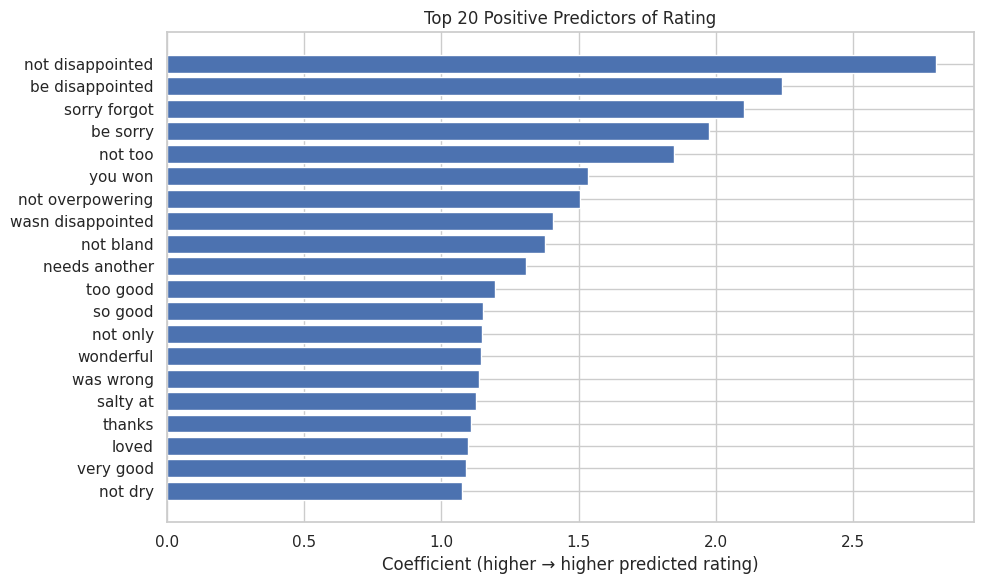

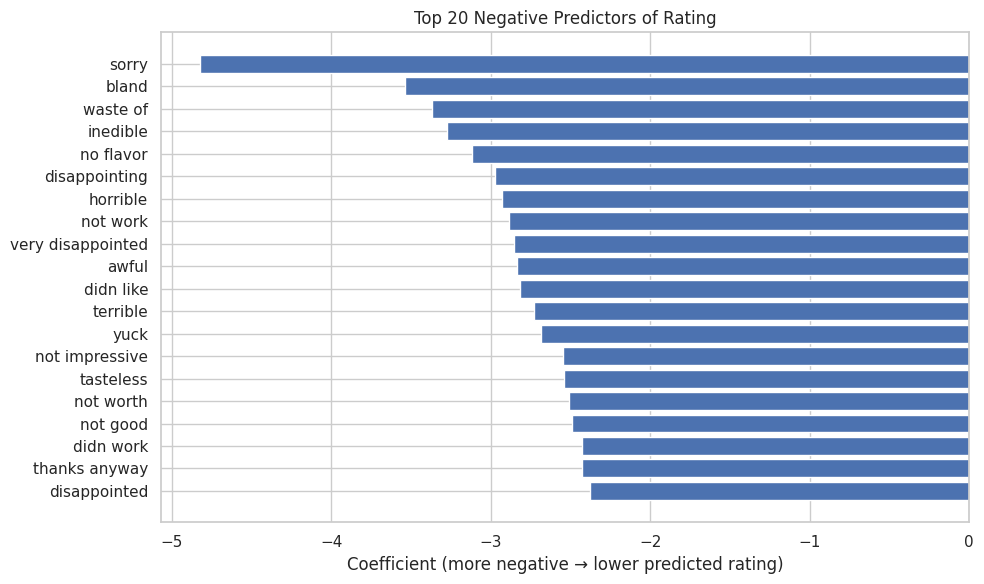

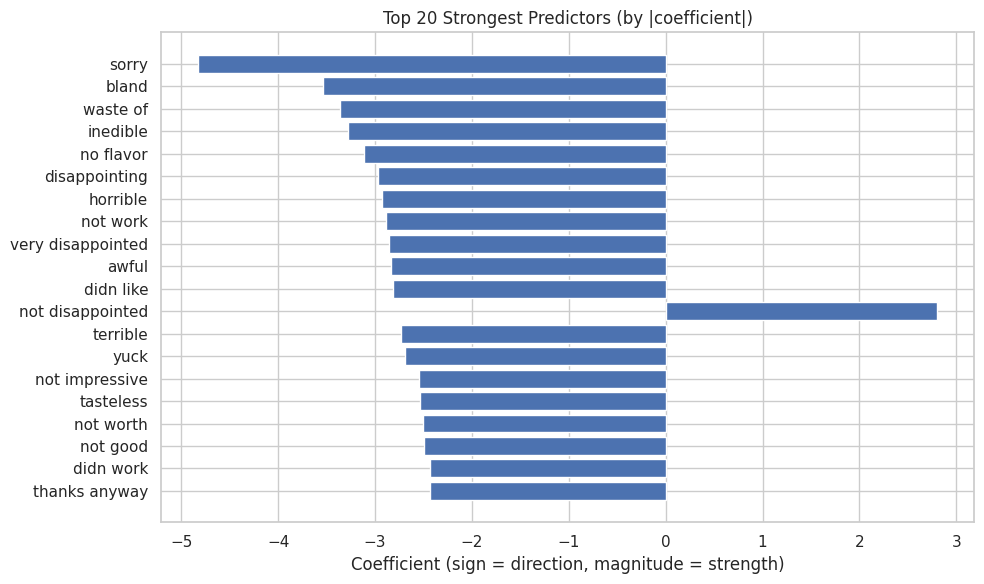

In [20]:
TOP_N = 20

# Top positive
df_pos = df_words.sort_values("coef", ascending=False).head(TOP_N)
# Top negative
df_neg = df_words.sort_values("coef", ascending=True).head(TOP_N)
# Top absolute
df_abs = df_words.sort_values("abs_coef", ascending=False).head(TOP_N)

plt.figure(figsize=(10, 6))
plt.barh(df_pos["word"][::-1], df_pos["coef"][::-1])
plt.title(f"Top {TOP_N} Positive Predictors of Rating")
plt.xlabel("Coefficient (higher → higher predicted rating)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(df_neg["word"][::-1], df_neg["coef"][::-1])
plt.title(f"Top {TOP_N} Negative Predictors of Rating")
plt.xlabel("Coefficient (more negative → lower predicted rating)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(df_abs["word"][::-1], df_abs["coef"][::-1])
plt.title(f"Top {TOP_N} Strongest Predictors (by |coefficient|)")
plt.xlabel("Coefficient (sign = direction, magnitude = strength)")
plt.tight_layout()
plt.show()


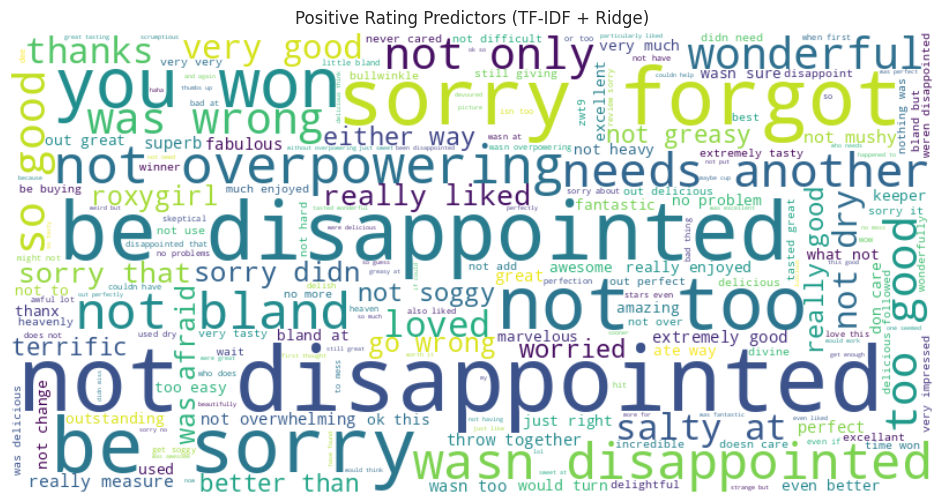

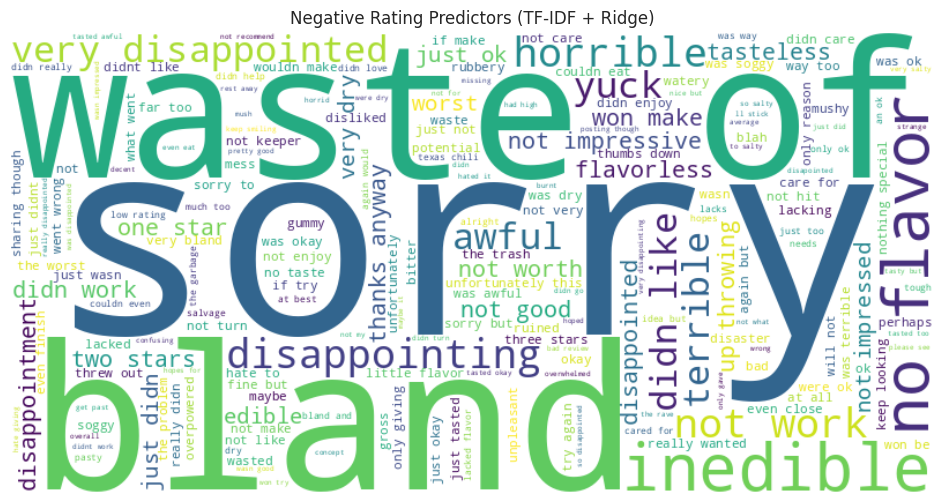

In [21]:
# Positive words: weight by coef (only coef > 0)
pos_words = df_words[df_words["coef"] > 0].copy()
pos_freq = dict(zip(pos_words["word"], pos_words["coef"]))

# Negative words: weight by |coef| (coef < 0)
neg_words = df_words[df_words["coef"] < 0].copy()
neg_freq = dict(zip(neg_words["word"], neg_words["abs_coef"]))

# Positive word cloud
wc_pos = WordCloud(width=800, height=400, background_color="white")
wc_pos.generate_from_frequencies(pos_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Rating Predictors (TF-IDF + Ridge)")
plt.show()

# Negative word cloud
wc_neg = WordCloud(width=800, height=400, background_color="white")
wc_neg.generate_from_frequencies(neg_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Rating Predictors (TF-IDF + Ridge)")
plt.show()


In [22]:
print("Top positive words:")
display(df_pos)

print("Top negative words:")
display(df_neg)

print("Top absolute influence words:")
display(df_abs)


Top positive words:


,word,coef,abs_coef
110636,not disappointed,2.801112,2.801112
18124,be disappointed,2.240882,2.240882
151065,sorry forgot,2.103350,2.103350
18522,be sorry,1.976898,1.976898
111175,not too,1.847780,1.847780
198535,you won,1.535560,1.535560
110941,not overpowering,1.507008,1.507008
188156,wasn disappointed,1.406455,1.406455
110521,not bland,1.377784,1.377784
108355,needs another,1.306783,1.306783


Top negative words:


,word,coef,abs_coef
151051,sorry,-4.824216,4.824216
22346,bland,-3.539956,3.539956
188293,waste of,-3.365256,3.365256
81766,inedible,-3.274314,3.274314
109844,no flavor,-3.114416,3.114416
47049,disappointing,-2.972775,2.972775
78004,horrible,-2.931435,2.931435
111227,not work,-2.887796,2.887796
185522,very disappointed,-2.854267,2.854267
15813,awful,-2.833030,2.833030


Top absolute influence words:


,word,coef,abs_coef
151051,sorry,-4.824216,4.824216
22346,bland,-3.539956,3.539956
188293,waste of,-3.365256,3.365256
81766,inedible,-3.274314,3.274314
109844,no flavor,-3.114416,3.114416
47049,disappointing,-2.972775,2.972775
78004,horrible,-2.931435,2.931435
111227,not work,-2.887796,2.887796
185522,very disappointed,-2.854267,2.854267
15813,awful,-2.833030,2.833030
